In [34]:
#Imports
from osgeo import gdal, osr
import rasterio
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import re

## Functions

In [35]:
def convert_rcp(filepath: str) -> dict:
    # Regular expression pattern to extract the RPC values
    pattern = r'(-?\d+(?:\.\d+)?)'

    # Read the RPC values from the text file
    with open(filepath, 'r') as file:
        rpc_values = file.read()

    # Extract the RPC values using the regular expression
    values = [str(x) for x in re.findall(pattern, rpc_values)]

    # Create a dictionary with the keys and values
    rpc_dict = {
        'LINE_OFF': values[0],
        'SAMP_OFF': values[1],
        'LAT_OFF': values[2],
        'LONG_OFF': values[3],
        'HEIGHT_OFF': values[4],
        'LINE_SCALE': values[5],
        'SAMP_SCALE': values[6],
        'LAT_SCALE': values[7],
        'LONG_SCALE': values[8],
        'HEIGHT_SCALE': values[9],
        'LINE_NUM_COEFF': ' '.join(values[10:30]),
        'LINE_DEN_COEFF': ' '.join(values[30:50]),
        'SAMP_NUM_COEFF': ' '.join(values[50:70]),
        'SAMP_DEN_COEFF': ' '.join(values[70:90]),
    	'MIN_LONG': values[91],
        'MIN_LAT': values[92],
        'MAX_LONG': values[93],
        'MAX_LAT': values[94],
        'sampleOFFSET': values[95],
        #'lineOFFSET': values[96],
    }
    return rpc_dict

In [36]:
#CANT use this due to missing stereo_calibration_matrix
def generate_dem(cv_image1, cv_image2, output:str):
    # Set up the stereo block matching algorithm
    bm = cv2.StereoBM_create()

    # Compute the disparity map
    disparity = bm.compute(cv_image1, cv_image2)

    # Convert the disparity map to a 3D point cloud
    points_3d = cv2.reprojectImageTo3D(disparity, stereo_calibration_matrix)

    # Save the point cloud to a file
    np.save(output, points_3d)

In [37]:
def warp_image(image_ds, rpc, output):
    # Create a georeferenced version of the image using the RPCs
    driver = gdal.GetDriverByName('GTiff')
    georef_ds = driver.Create(f'{PATH_TO_TEMP}georef.tif', image_ds.RasterXSize, image_ds.RasterYSize, image_ds.RasterCount, gdal.GDT_Byte)
    georef_ds.SetMetadata(rpc, 'RPC')
    georef_ds.GetRasterBand(1).WriteArray(image_ds.GetRasterBand(1).ReadAsArray())
    #print(georef_ds.GetMetadata('RPC'))
    image_ds = None
    georef_ds = None

    # Reproject the images to the same projection (EPSG:3857 in this case)
    # EPSG:4326, EPSG:7789 also not working
    gdal.Warp(output, f'{PATH_TO_TEMP}georef.tif')
    os.remove(f'{PATH_TO_TEMP}georef.tif')

In [38]:
def stitch_images(cv_image1, cv_image2, outputpath:str):
    # Create the stitcher object
    stitcher = cv2.Stitcher.create()

    # Stitch the images together
    status, stitched_image = stitcher.stitch((cv_image1, cv_image2))

    # Check if the stitching was successful
    if status == cv2.Stitcher_OK:
        # Save the stitched image
        cv2.imwrite(outputpath, stitched_image)
        return stitched_image
    else:
        print(f'Stitching failed! with error {status}')
        return -1
    

In [39]:
def get_disparity_map(cv_image1, cv_image2, roi:list=None) -> np.ndarray:    
    
    if roi is not None:
        # Crop the images to the same size
        cv_image1 = cv_image1[roi[0]:roi[1], roi[2]:roi[3]]
        cv_image2 = cv_image2[roi[0]:roi[1], roi[2]:roi[3]]

    # Convert the images to grayscale
    gray_1 = cv2.cvtColor(cv_image1, cv2.COLOR_BGR2GRAY)
    gray_2 = cv2.cvtColor(cv_image2, cv2.COLOR_BGR2GRAY)



    # Set up the block matching algorithm
    bm = cv2.StereoBM_create()

    #print(image_1.shape, image_2.shape)

    # Compute the disparity map
    return bm.compute(gray_1, gray_2)

In [40]:
def plot_3d_reconstruction(disparity:np.ndarray, rpc_1:dict, rpc_2:dict) -> None:    
    focal_length = 13.5*(10**(-3)) # Focal length in meters found by chatGPT

    # Compute the baseline using the RPCs
    baseline = np.abs(float(rpc_1['LINE_OFF']) - float(rpc_2['LINE_OFF']))
    depth = focal_length * baseline / disparity

    x, y = np.meshgrid(np.arange(3001),np.arange(3001))
    # Create a figure and a 3D Axes
    fig = plt.figure(figsize=(8,4.5))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points
    ax.scatter(x, y, depth)

    # Show the plot
    plt.show()

In [41]:
def crop_images(image1_path:str, image2_path:str):

    # Open the first image
    ds1 = gdal.Open(image1_path)

    # Read the georeferencing information
    geotransform = ds1.GetGeoTransform()
    srs = osr.SpatialReference()
    srs.ImportFromWkt(ds1.GetProjection())

    # Get the size of the image in pixels
    x_size, y_size = ds1.GetRasterBand(1).GetBlockSize()

    # Calculate the extent of the image in the original projection
    min_x = abs(geotransform[0])
    max_x = abs(geotransform[0]) + abs(x_size * geotransform[1])
    min_y = abs(geotransform[3]) + abs(y_size * geotransform[5])
    max_y = abs(geotransform[3])
    extent_1 = (min_x, max_x, min_y, max_y)

    # Open the second image
    ds2 = gdal.Open(image2_path)

    # Read the georeferencing information
    geotransform = ds2.GetGeoTransform()
    srs = osr.SpatialReference()
    srs.ImportFromWkt(ds2.GetProjection())

    # Get the size of the image in pixels
    x_size, y_size = ds2.GetRasterBand(1).GetBlockSize()

    # Calculate the extent of the image in the original projection
    min_x = abs(geotransform[0])
    max_x = abs(geotransform[0]) + abs(x_size * geotransform[1])
    min_y = abs(geotransform[3]) + abs(y_size * geotransform[5])
    max_y = abs(geotransform[3])
    extent_2 = (min_x, max_x, min_y, max_y)

    # Calculate the intersection of the two extents
    min_x = max(extent_1[0], extent_2[0])
    max_x = min(extent_1[1], extent_2[1])
    min_y = max(extent_1[2], extent_2[2])
    max_y = min(extent_1[3], extent_2[3])

    # Crop the images to the intersection extent
    ds1_cropped = gdal.Translate('image_1_cropped.tif', ds1, projWin=[min_x, max_y, max_x, min_y])
    ds2_cropped = gdal.Translate('image_2_cropped.tif', ds2, projWin=[min_x, max_y, max_x, min_y])
    return ds1_cropped, ds2_cropped

In [42]:
def write_rpc_into_geotiff(image_ds_name, rpc_name) -> None:
    image_ds = gdal.Open(image_ds_name)
    rpc = convert_rcp(rpc_name)

    driver = gdal.GetDriverByName('GTiff')
    georef_ds = driver.Create(image_ds_name, image_ds.RasterXSize, image_ds.RasterYSize, image_ds.RasterCount, gdal.GDT_Byte)
    georef_ds.SetMetadata(rpc, 'RPC')
    georef_ds.GetRasterBand(1).WriteArray(image_ds.GetRasterBand(1).ReadAsArray())
    image_ds = None
    georef_ds = None

In [45]:
def calculate_3d_points (disparity:np.ndarray, rpc_1:dict, rpc_2:dict) -> np.ndarray:
    # Extract the RPC coefficients
    line_num_coeff_1 = np.array(rpc_1['LINE_NUM_COEFF'].split(), dtype=float)
    line_den_coeff_1 = np.array(rpc_1['LINE_DEN_COEFF'].split(), dtype=float)
    samp_num_coeff_1 = np.array(rpc_1['SAMP_NUM_COEFF'].split(), dtype=float)
    samp_den_coeff_1 = np.array(rpc_1['SAMP_DEN_COEFF'].split(), dtype=float)

    line_num_coeff_2 = np.array(rpc_2['LINE_NUM_COEFF'].split(), dtype=float)
    line_den_coeff_2 = np.array(rpc_2['LINE_DEN_COEFF'].split(), dtype=float)
    samp_num_coeff_2 = np.array(rpc_2['SAMP_NUM_COEFF'].split(), dtype=float)
    samp_den_coeff_2 = np.array(rpc_2['SAMP_DEN_COEFF'].split(), dtype=float)
    # Estimate the 3D positions of the points in the left image using the RPCs
    num_rows, num_cols = disparity.shape
    points_3d_1 = np.empty((num_rows, num_cols, 3))
    for i in range(num_rows):
        for j in range(num_cols):
            points_3d_1[i,j,0] = (line_num_coeff_1[0] + line_num_coeff_1[1] * i + line_num_coeff_1[2] * j + line_num_coeff_1[3] * i * j + line_num_coeff_1[4] * i**2 + line_num_coeff_1[5] * j**2) / (line_den_coeff_1[0] + line_den_coeff_1[1] * i + line_den_coeff_1[2] * j + line_den_coeff_1[3] * i * j + line_den_coeff_1[4] * i**2 + line_den_coeff_1[5] * j**2)
            points_3d_1[i,j,1] = (samp_num_coeff_1[0] + samp_num_coeff_1[1] * i + samp_num_coeff_1[2] * j + samp_num_coeff_1[3] * i * j + samp_num_coeff_1[4] * i**2 + samp_num_coeff_1[5] * j**2) / (samp_den_coeff_1[0] + samp_den_coeff_1[1] * i + samp_den_coeff_1[2] * j + samp_den_coeff_1[3] * i * j + samp_den_coeff_1[4] * i**2 + samp_den_coeff_1[5] * j**2)
            points_3d_1[i,j,2] = (points_3d_1[i,j,0] - points_3d_1[i,j,1]) * disparity[i, j]
    # Estimate the 3D positions of the points in the right image using the RPCs
    points_3d_2 = np.empty((num_rows, num_cols, 3))
    for i in range(num_rows):
        for j in range(num_cols):
            points_3d_2[i,j,0] = (line_num_coeff_2[0] + line_num_coeff_2[1] * i + line_num_coeff_2[2] * j + line_num_coeff_2[3] * i * j + line_num_coeff_2[4] * i**2 + line_num_coeff_2[5] * j**2) / (line_den_coeff_2[0] + line_den_coeff_2[1] * i + line_den_coeff_2[2] * j + line_den_coeff_2[3] * i * j + line_den_coeff_2[4] * i**2 + line_den_coeff_2[5] * j**2)
            points_3d_2[i,j,1] = (samp_num_coeff_2[0] + samp_num_coeff_2[1] * i + samp_num_coeff_2[2] * j + samp_num_coeff_2[3] * i * j + samp_num_coeff_2[4] * i**2 + samp_num_coeff_2[5] * j**2) / (samp_den_coeff_2[0] + samp_den_coeff_2[1] * i + samp_den_coeff_2[2] * j + samp_den_coeff_2[3] * i * j + samp_den_coeff_2[4] * i**2 + samp_den_coeff_2[5] * j**2)
            points_3d_2[i,j,2] = (points_3d_2[i,j,0] - points_3d_2[i,j,1]) * disparity[i, j]

    return points_3d_1, points_3d_2

In [46]:
def plot_3d(points):
    # Extract the x, y, and z coordinates of the points
    x = points[:, :, 0]
    y = points[:, :, 1]
    z = points[:, :, 2]

    # Create a figure and a 3D Axes
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points
    ax.scatter(x, y, z)

    # Show the plot
    plt.show()

## Main Function

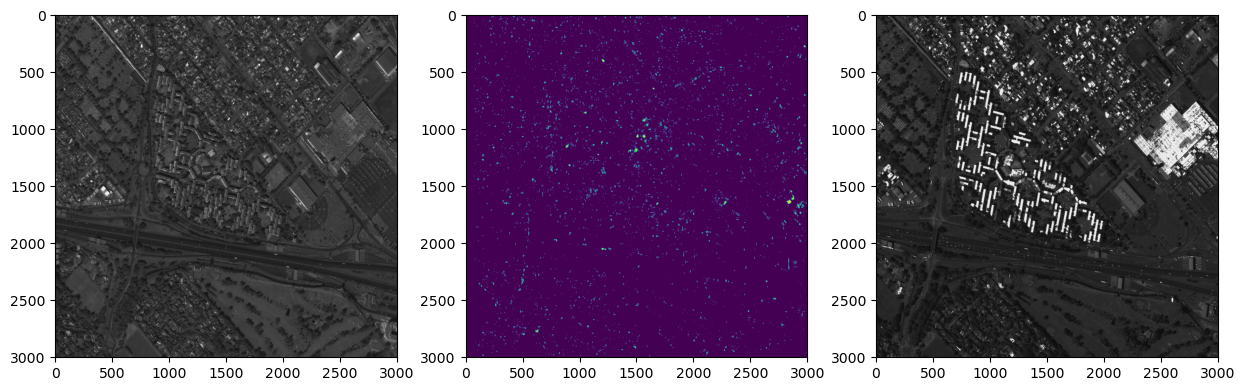

In [75]:
#MAIN
# defines
PATH_TO_IMAGES = '/root/PLUS-IBBC/testimgs/'
PATH_TO_TEMP = '/root/PLUS-IBBC/temp/'
IMAGES = ['03.tif', '04.tif']
# Open the images as datasets
image_1_ds = gdal.Open(f'{PATH_TO_IMAGES}{IMAGES[0]}')
image_2_ds = gdal.Open(f'{PATH_TO_IMAGES}{IMAGES[1]}')

# Get the RPCs for the images
rpc_1 = convert_rcp(f'{PATH_TO_IMAGES}rpc_{IMAGES[0][:-4]}.txt')
rpc_2 = convert_rcp(f'{PATH_TO_IMAGES}rpc_{IMAGES[1][:-4]}.txt')

#Open the images with opencv
image_1 = cv2.imread(f'{PATH_TO_IMAGES}{IMAGES[0]}')
image_2 = cv2.imread(f'{PATH_TO_IMAGES}{IMAGES[1]}')

# Get the disparity map
disparity = get_disparity_map(image_1, image_2)

# Plot the disparity map and left image
fig = plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(image_1)
plt.subplot(132)
plt.imshow(disparity)
plt.subplot(133)
plt.imshow(image_2)
plt.show()

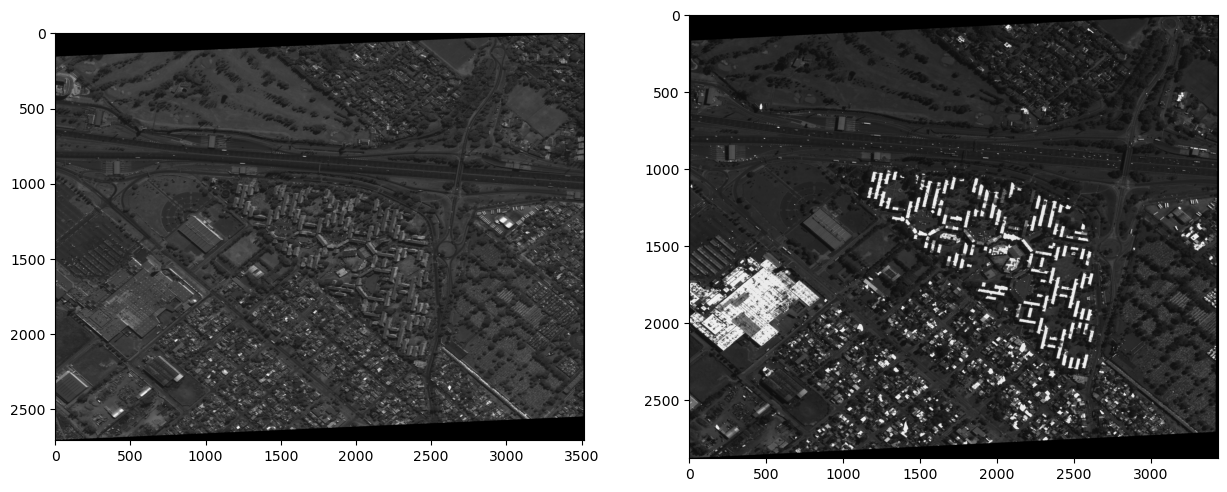

In [76]:
# Warp images to ground coordinates
REPROJECTED_IMAGES = ['image1_reprojected.tif', 'image2_reprojected.tif']
warp_image(image_1_ds,rpc_1,f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[0]}')
warp_image(image_2_ds,rpc_2,f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[1]}')

# Open the reprojected images
image_1_reprojected = cv2.imread(f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[0]}')
image_2_reprojected = cv2.imread(f'{PATH_TO_TEMP}{REPROJECTED_IMAGES[1]}')

# Plot the reprojected images
fig = plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(image_1_reprojected)
plt.subplot(122)
plt.imshow(image_2_reprojected)
plt.show()


Stitching failed!


TypeError: Invalid shape () for image data

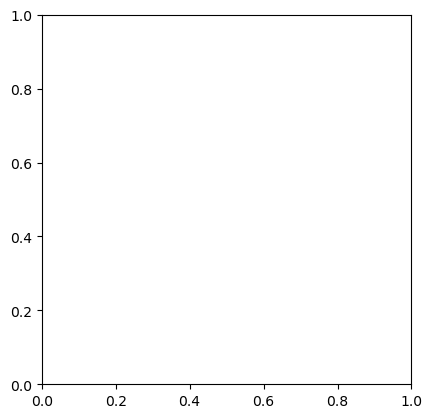

In [77]:
# Stitch images
stitched_image = stitch_images(image_1,image_2,f'{PATH_TO_TEMP}stitched_image.tif')

# Plot the stitched image
plt.imshow(stitched_image)
plt.show()

In [74]:
# Clear tmp folder
for file in os.listdir(PATH_TO_TEMP):
    os.remove(f'{PATH_TO_TEMP}{file}')

In [63]:
#3D reconstruction
#TODO: Check why division by zero error in disparity
#plot_3d_reconstruction(disparity, rpc_1, rpc_2)
points_left, points_right = calculate_3d_points(disparity, rpc_1, rpc_2)
plot_3d(points_left)
plot_3d(points_right)

KeyboardInterrupt: 

In [ ]:
#TODO: CHECK IF WE STILL NEED DIS?
# Estimate the relative depths of the pixels using the RPCs
image_1_ds = gdal.Open('img_01.tif')
image_2_ds = gdal.Open('img_02.tif')

rpc_1 = image_1_ds.GetMetadata('RPC')
rpc_2 = image_2_ds.GetMetadata('RPC')
#rpc_1 = convert_rcp('/root/PLUS-IBBC/rpc_05.txt')
#rpc_2 = convert_rcp('/root/PLUS-IBBC/rpc_06.txt')



## HELP STUFF:
This stuff is to figure out what actually is in an image, and to modify the images

In [ ]:
# Open the image
image_ds = gdal.Open('02.tif')
image_test = gdal.Open('01.tif')

# Get the RPCs for the image
rpc = image_ds.GetMetadata('RPC')
print(image_ds.GetMetadataDomainList())
print(image_test.GetMetadataDomainList())
print(image_ds.GetMetadata('RPC'))
print(image_test.GetMetadata('RPC'))

['IMAGE_STRUCTURE', 'RPC', 'DERIVED_SUBDATASETS']
['IMAGE_STRUCTURE', 'DERIVED_SUBDATASETS', 'RPC']
{'ERR_BIAS': '-1', 'ERR_RAND': '-1', 'HEIGHT_OFF': '1295', 'HEIGHT_SCALE': '1315', 'LAT_OFF': '-21.2316081288', 'LAT_SCALE': '0.0911805852907', 'LINE_DEN_COEFF': '1 0.000997771806716 0.000893795146776 -2.56359129684e-05 -1.70851501528e-05 -3.21867506534e-07 2.1532776166e-05 8.13369760723e-05 -0.000270733342464 0.000126355623049 -3.65549547543e-07 1.73348528132e-07 1.0566912918e-05 2.48524027091e-07 5.68010228875e-07 -3.14981737526e-06 -1.46513589459e-07 -1.44200775386e-08 1.59078686184e-06 -3.43796798432e-09', 'LINE_NUM_COEFF': '-37.284870906 -0.389307964671 -39.0126569672 0.756244483967 0.0365724832883 -0.000699590543671 5.69148667027e-05 0.00488795358124 -0.0493487209079 -0.00486335415172 6.61460426948e-05 -4.3251938614e-05 -0.00106436732503 -5.45489448461e-05 -0.00330149225713 -0.0169088089294 -0.00493745513823 6.47041405124e-05 0.000507944645931 9.58883770134e-05', 'LINE_OFF': '19403

In [ ]:
# Write RPCs into image
images = ['06.tif']
rpcs = ['rpc_06.txt']

for image_ds_name, rpc_name in images, rpcs:
    write_rpc_into_geotiff(image_ds_name, rpc_name)